## Case Study 3: EDEG/JDEG Analysis Using the PDAC Dataset

In this example, we demonstrate how to perform Exon-level Differential Expression Genes(EDEG) and Junction-level Differential Expression (JDEG) analysis using pancreatic ductal adenocarcinoma (PDAC) dataset.

The processed PDAC dataset can be downloaded from this [link](https://mcgill-my.sharepoint.com/:f:/g/personal/kailu_song_mail_mcgill_ca/EvZtHeW7qjJJs_RHc2-327ABeLXafa-ruvfk9Vs134crig?e=kEPtAV)

## Step 1: Get Cell Embedding

In [14]:
from DOLPHIN.model import run_DOLPHIN
import numpy as np

In [ ]:
#load datasets
graph_data = "./pdac_dataset/geometric_PDAC.pt"
feature_data = "./pdac_dataset/FeatureCompHvg_PDAC.h5ad"
## save the output adata, default is set to the current folder
output_path = './'

In [3]:
run_DOLPHIN("10x", graph_data, feature_data, output_path, seed_num=11)

/mnt/md1/kailu/DOLPHIN/DOLPHIN/model/train.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pg_celldata = torch.load(in_path_gp)


[epoch 000] training loss: 14535.1321
[epoch 001] training loss: 9484.0300
[epoch 002] training loss: 8842.7456
[epoch 003] training loss: 8384.2322
[epoch 004] training loss: 8002.3027
[epoch 005] training loss: 7665.4353
[epoch 006] training loss: 7354.3001
[epoch 007] training loss: 7065.6936
[epoch 008] training loss: 6797.6924
[epoch 009] training loss: 6545.2808
[epoch 010] training loss: 6310.4178
[epoch 011] training loss: 6089.4171
[epoch 012] training loss: 5881.0074
[epoch 013] training loss: 5683.9913
[epoch 014] training loss: 5497.7865
[epoch 015] training loss: 5323.6587
[epoch 016] training loss: 5158.4423
[epoch 017] training loss: 5003.3073
[epoch 018] training loss: 4854.2198
[epoch 019] training loss: 4713.8004
[epoch 020] training loss: 4580.4292
[epoch 021] training loss: 4453.9250
[epoch 022] training loss: 4334.3721
[epoch 023] training loss: 4221.1840
[epoch 024] training loss: 4112.2491
[epoch 025] training loss: 4008.7768
[epoch 026] training loss: 3910.0151


In [4]:
import scanpy as sc
from sklearn.metrics import adjusted_rand_score

The result is saved at this [link](https://mcgill-my.sharepoint.com/my?id=%2Fpersonal%2Fkailu%5Fsong%5Fmail%5Fmcgill%5Fca%2FDocuments%2FDeepExonas%5Fgithub%5Fexample%2Fprocessed%5Fdataset)

In [5]:
adata = sc.read_h5ad("./DOLPHIN_Z.h5ad")

In [ ]:
sc.pp.neighbors(adata, use_rep="X_z")
sc.tl.umap(adata)
sc.tl.leiden(adata, 0.4, random_state=0)
print(len(set(adata.obs["leiden"])))
adjusted_rand_score(adata.obs["cluster"], adata.obs["leiden"])

/tmp/ipykernel_428312/347401036.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, 0.4, random_state=0)


10


0.830919522944064

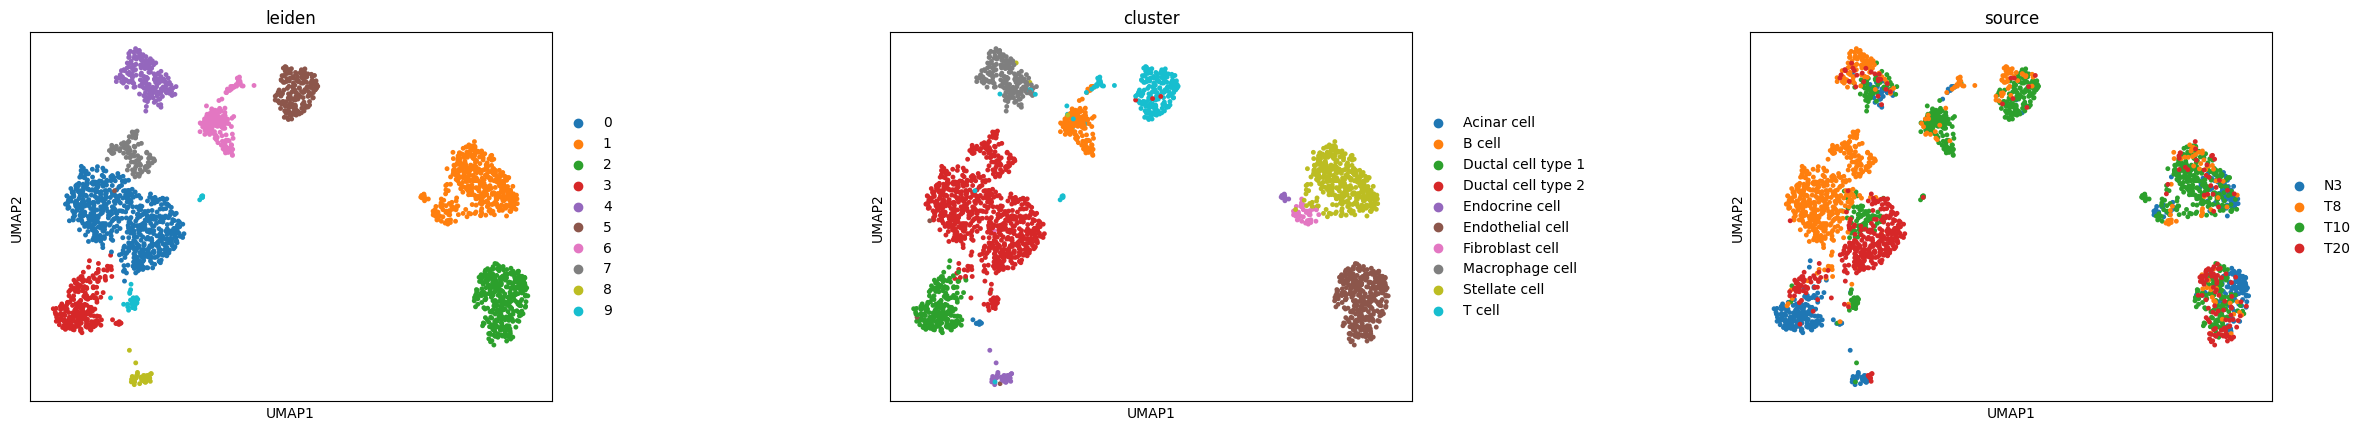

In [12]:
sc.pl.umap(adata, color=['leiden', "cluster", "source"], wspace=0.5)

## Step 2: Get Exon-Level and Junction-Level Markers Using MAST

In this step, we identify exon-level markers using the MAST framework. The output is then used to derive exon-level differential expression (EDEG) and junction-level differential expression (JDEG).

Please follow the tutorials below:

- **Exon-Level/Junction-Level Marker Detection with MAST**  
  [Step 7.1: MAST Exon Marker Detection](../tutorials/step7_1_MAST.ipynb)

- **EDEG Aggregation from Exon-Level Results**  
  [Step 7.2: Exon-Level Aggregation to EDEG](../tutorials/step7_2_exon_level.ipynb)

- **JDEG Analysis Based on Junction Markers**  
  [Step 7.3: Junction-Level Differential Expression](../tutorials/step7_3_junction_level.ipynb)

Once the statistical analysis is completed, EDEGs and JDEGs are selected using the following thresholds:
- Adjusted p-value < 0.05
- Absolute log2 fold change > 1

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib_venn import venn2
import os
from scipy.stats import wilcoxon

In [ ]:
leiden_res = "leiden_0_4_8"
cluster_num = "2"
gene_type = "MAST"

In [ ]:
## load the MAST results using the exon matrix as input.
df_exon_DE = pd.read_csv("/Feature_"+leiden_res+"_cluster_"+cluster_num+".csv")

## load the MAST results using the gene count table as input.
df_scanpy_DE = pd.read_csv("./Gene_"+leiden_res+"_cluster_"+cluster_num+"_MAST_v2_GeneRemap.csv")

df_exon_DE_sub = df_exon_DE[(df_exon_DE[gene_type+"_weighted_stouffer_pval_adj_bonf"] < 0.05) & (abs(df_exon_DE[gene_type+"_weighted_abs_avg_log2FC"]) > 1)].copy()
df_scanpy_DE_sub = df_scanpy_DE[(df_scanpy_DE[gene_type+"_pvals_adj"]<0.05) & (abs(df_scanpy_DE[gene_type+"_logfoldchanges"]) >1)].copy()

print("Number of DE in exon:", len(set(df_exon_DE_sub["Cancer_gene_names"])))
print("Number of DE in scanpy:", len(set(df_scanpy_DE_sub["Cancer_names_remap"])))

df_exon_DE_sub_unique = df_exon_DE_sub[~df_exon_DE_sub["Cancer_gene_names"].isin(df_scanpy_DE_sub["Cancer_names_remap"])]
print("Number of Unique DE in Exon:", len(set(df_exon_DE_sub_unique["Cancer_gene_names"])))

Number of DE in exon: 2339
Number of DE in scanpy: 1926
Number of Unique DE in Exon: 896


In [ ]:
df_scanpy_DE_sub_unique = df_scanpy_DE_sub[~df_scanpy_DE_sub["Cancer_names_remap"].isin(df_exon_DE_sub["Cancer_gene_names"])]
print("Number of Unique DE in Scanpy:", len(set(df_scanpy_DE_sub_unique["Cancer_names_remap"])))

Number of Unique DE in Scanpy: 483


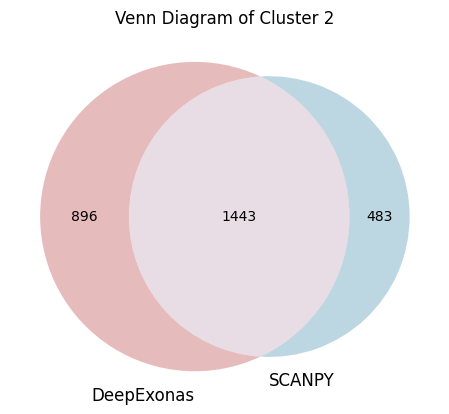

In [ ]:
venn_diagram = venn2([set(df_exon_DE_sub["Cancer_gene_names"]), set(df_scanpy_DE_sub["Cancer_names_remap"])], ('DeepExonas', 'SCANPY'), set_colors=('#C25759', '#599CB4'))

plt.title("Venn Diagram of Cluster "+cluster_num)
plt.show()
plt.close()

### Enrichment Analysis

Once the EDEGs and JDEGs are identified, we perform enrichment analysis using [ToppGene](https://toppgene.cchmc.org/prioritization.jsp). 


In [ ]:
## Load ToppGene Results for EDEG

go_exon = pd.read_csv("DE_exon.txt", sep="\t")
go_exon["Adjusted P-value"] = go_exon["q-value FDR B&H"]
go_exon["Term"] = go_exon["Name"]
go_exon["Gene_set"] = "DeepExonas"
go_exon_panc = go_exon[go_exon["Name"].str.contains("pancrea", case=False, na=False)].copy()

In [ ]:
## Load ToppGene Results for DEG

go_gene = pd.read_csv("DE_gene.txt", sep="\t")
go_gene["Adjusted P-value"] = go_gene["q-value FDR B&H"]
go_gene["Term"] = go_gene["Name"]
go_gene["Gene_set"] = "Gene"
go_gene_panc = go_gene[go_gene["Name"].str.contains("pancrea", case=False, na=False)].copy()

In [ ]:
from gseapy.plot import barplot, dotplot

pd_merge = pd.merge(go_exon_panc, go_gene_panc, on=["ID"], how="outer").rename(columns={"q-value FDR B&H_x":"q-value FDR B&H_exon", "q-value FDR B&H_y":"q-value FDR B&H_gene"})
pd_merge["Category"] = pd_merge['Category_x'].fillna(pd_merge['Category_y'])
pd_merge["Name"] = pd_merge['Name_x'].fillna(pd_merge['Name_y'])
pd_merge["q-value FDR B&H_exon"] = pd_merge['q-value FDR B&H_exon'].fillna(0)
pd_merge["q-value FDR B&H_gene"] = pd_merge['q-value FDR B&H_gene'].fillna(0)
pd_merge = pd_merge[["Category", "ID", "Name", "q-value FDR B&H_exon", "q-value FDR B&H_gene"]]
pd_merge = pd_merge[pd_merge["Category"]!="GO: Biological Process"]
pd_merge_final = pd_merge[pd_merge["Name"] != "TROPICAL CALCIFIC PANCREATITIS"]
len(pd_merge_final)

/mnt/data/kailu/anaconda3/envs/dvaegpuEnv/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/data/kailu/anaconda3/envs/dvaegpuEnv/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/mnt/data/kailu/anaconda3/envs/dvaegpuEnv/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_1868659/3377385327.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='-log10(FDR_exon)', y='Name', data=pd_merge_final, color='red', label='Exon',


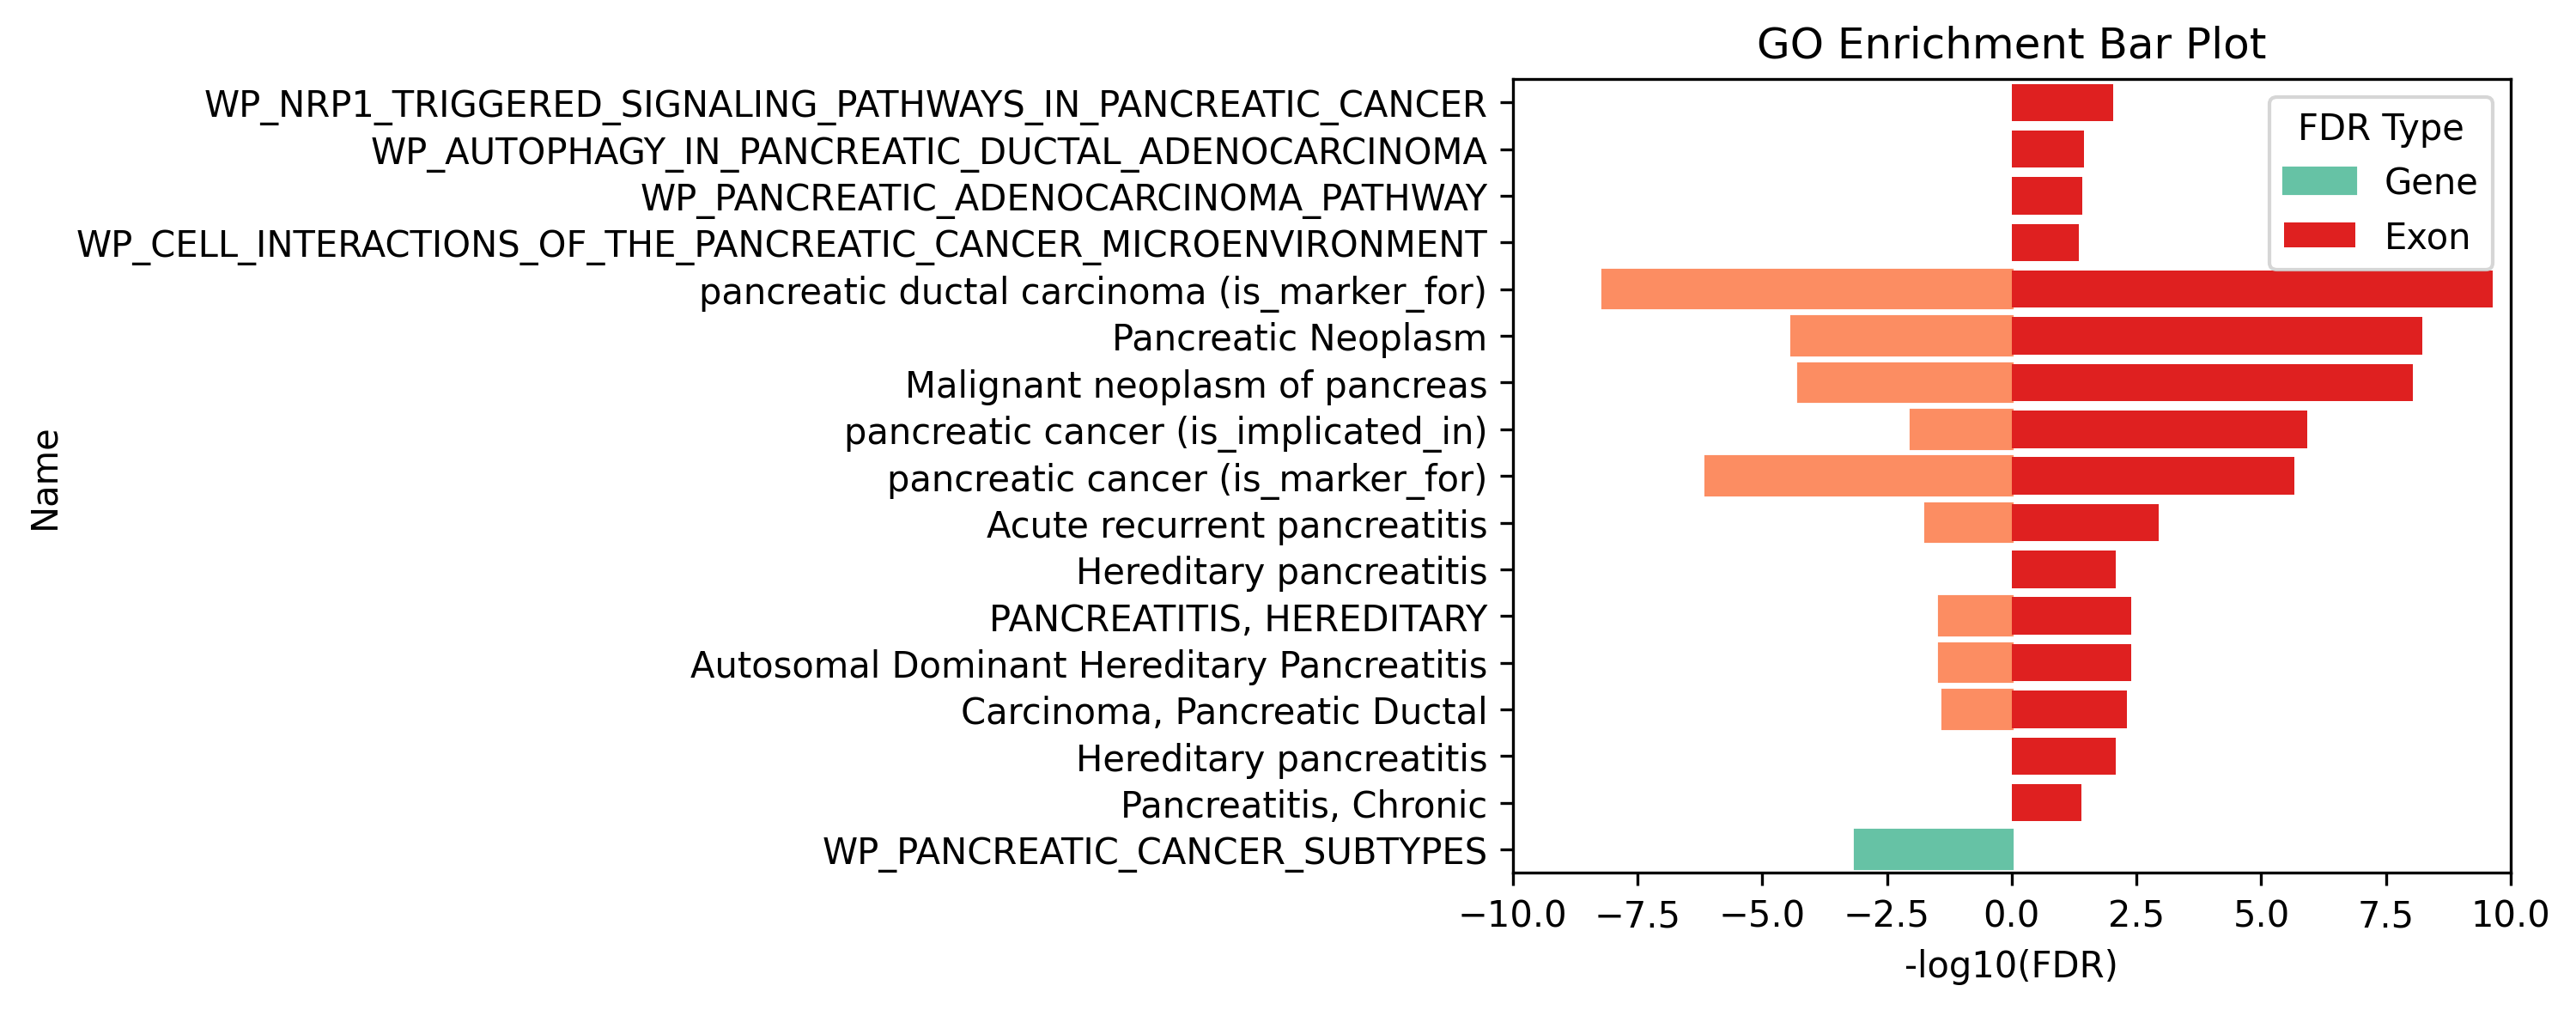

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare the data
pd_merge_final['-log10(FDR_gene)'] = np.log10(pd_merge_final['q-value FDR B&H_gene'])
pd_merge_final['-log10(FDR_exon)'] = -np.log10(pd_merge_final['q-value FDR B&H_exon'])

# Set color palette based on Category_x
categories = pd_merge_final['Category'].unique()
palette = sns.color_palette('Set2', len(categories))
category_colors = {category: palette[i] for i, category in enumerate(categories)}

# Plot
with plt.rc_context({"figure.figsize":(5,4), "figure.dpi": (300)}):
    # Bar plot for genes (left side)
    sns.barplot(x='-log10(FDR_gene)', y='Name', data=pd_merge_final, color='blue', label='Gene',
                order=pd_merge_final['Name'], orient='h')

    # Overlay bar plot for exons (right side)
    sns.barplot(x='-log10(FDR_exon)', y='Name', data=pd_merge_final, color='red', label='Exon',
                order=pd_merge_final['Name'], orient='h', ci=None)

    plt.xlim(-10, 10)
    plt.xlabel('-log10(FDR)')
    plt.ylabel('Name')
    plt.title('GO Enrichment Bar Plot')
    for index, category in enumerate(pd_merge_final['Category']):
        plt.gca().patches[index].set_color(category_colors[category])
    plt.legend(title='FDR Type', loc='upper right')
    plt.show()
    plt.close()

In [ ]:
## Load ToppGene Results for DEG-only, there is no pancrea related significant terms

go_unique_scanpy = pd.read_csv("DE_unique_scanpy.txt", sep="\t")
go_unique_scanpy["Adjusted P-value"] = go_unique_scanpy["q-value FDR B&H"]
go_unique_scanpy["Term"] = go_unique_scanpy["Name"]
go_unique_scanpy["Gene_set"] = go_unique_scanpy["Category"]
go_unique_scanpy_panc = go_unique_scanpy[go_unique_scanpy["Name"].str.contains("pancrea", case=False, na=False)].copy()
len(go_unique_scanpy_panc)

0

In [ ]:
## Load ToppGene Results for EDEG-only

go_unique_exon = pd.read_csv("DE_unique_exon.txt", sep="\t")
go_unique_exon["Adjusted P-value"] = go_unique_exon["q-value FDR B&H"]
go_unique_exon["Term"] = go_unique_exon["Name"]
go_unique_exon["Gene_set"] = go_unique_exon["Category"]

go_unique_exon_panc = go_unique_exon[go_unique_exon["Name"].str.contains("pancrea", case=False, na=False)].copy()

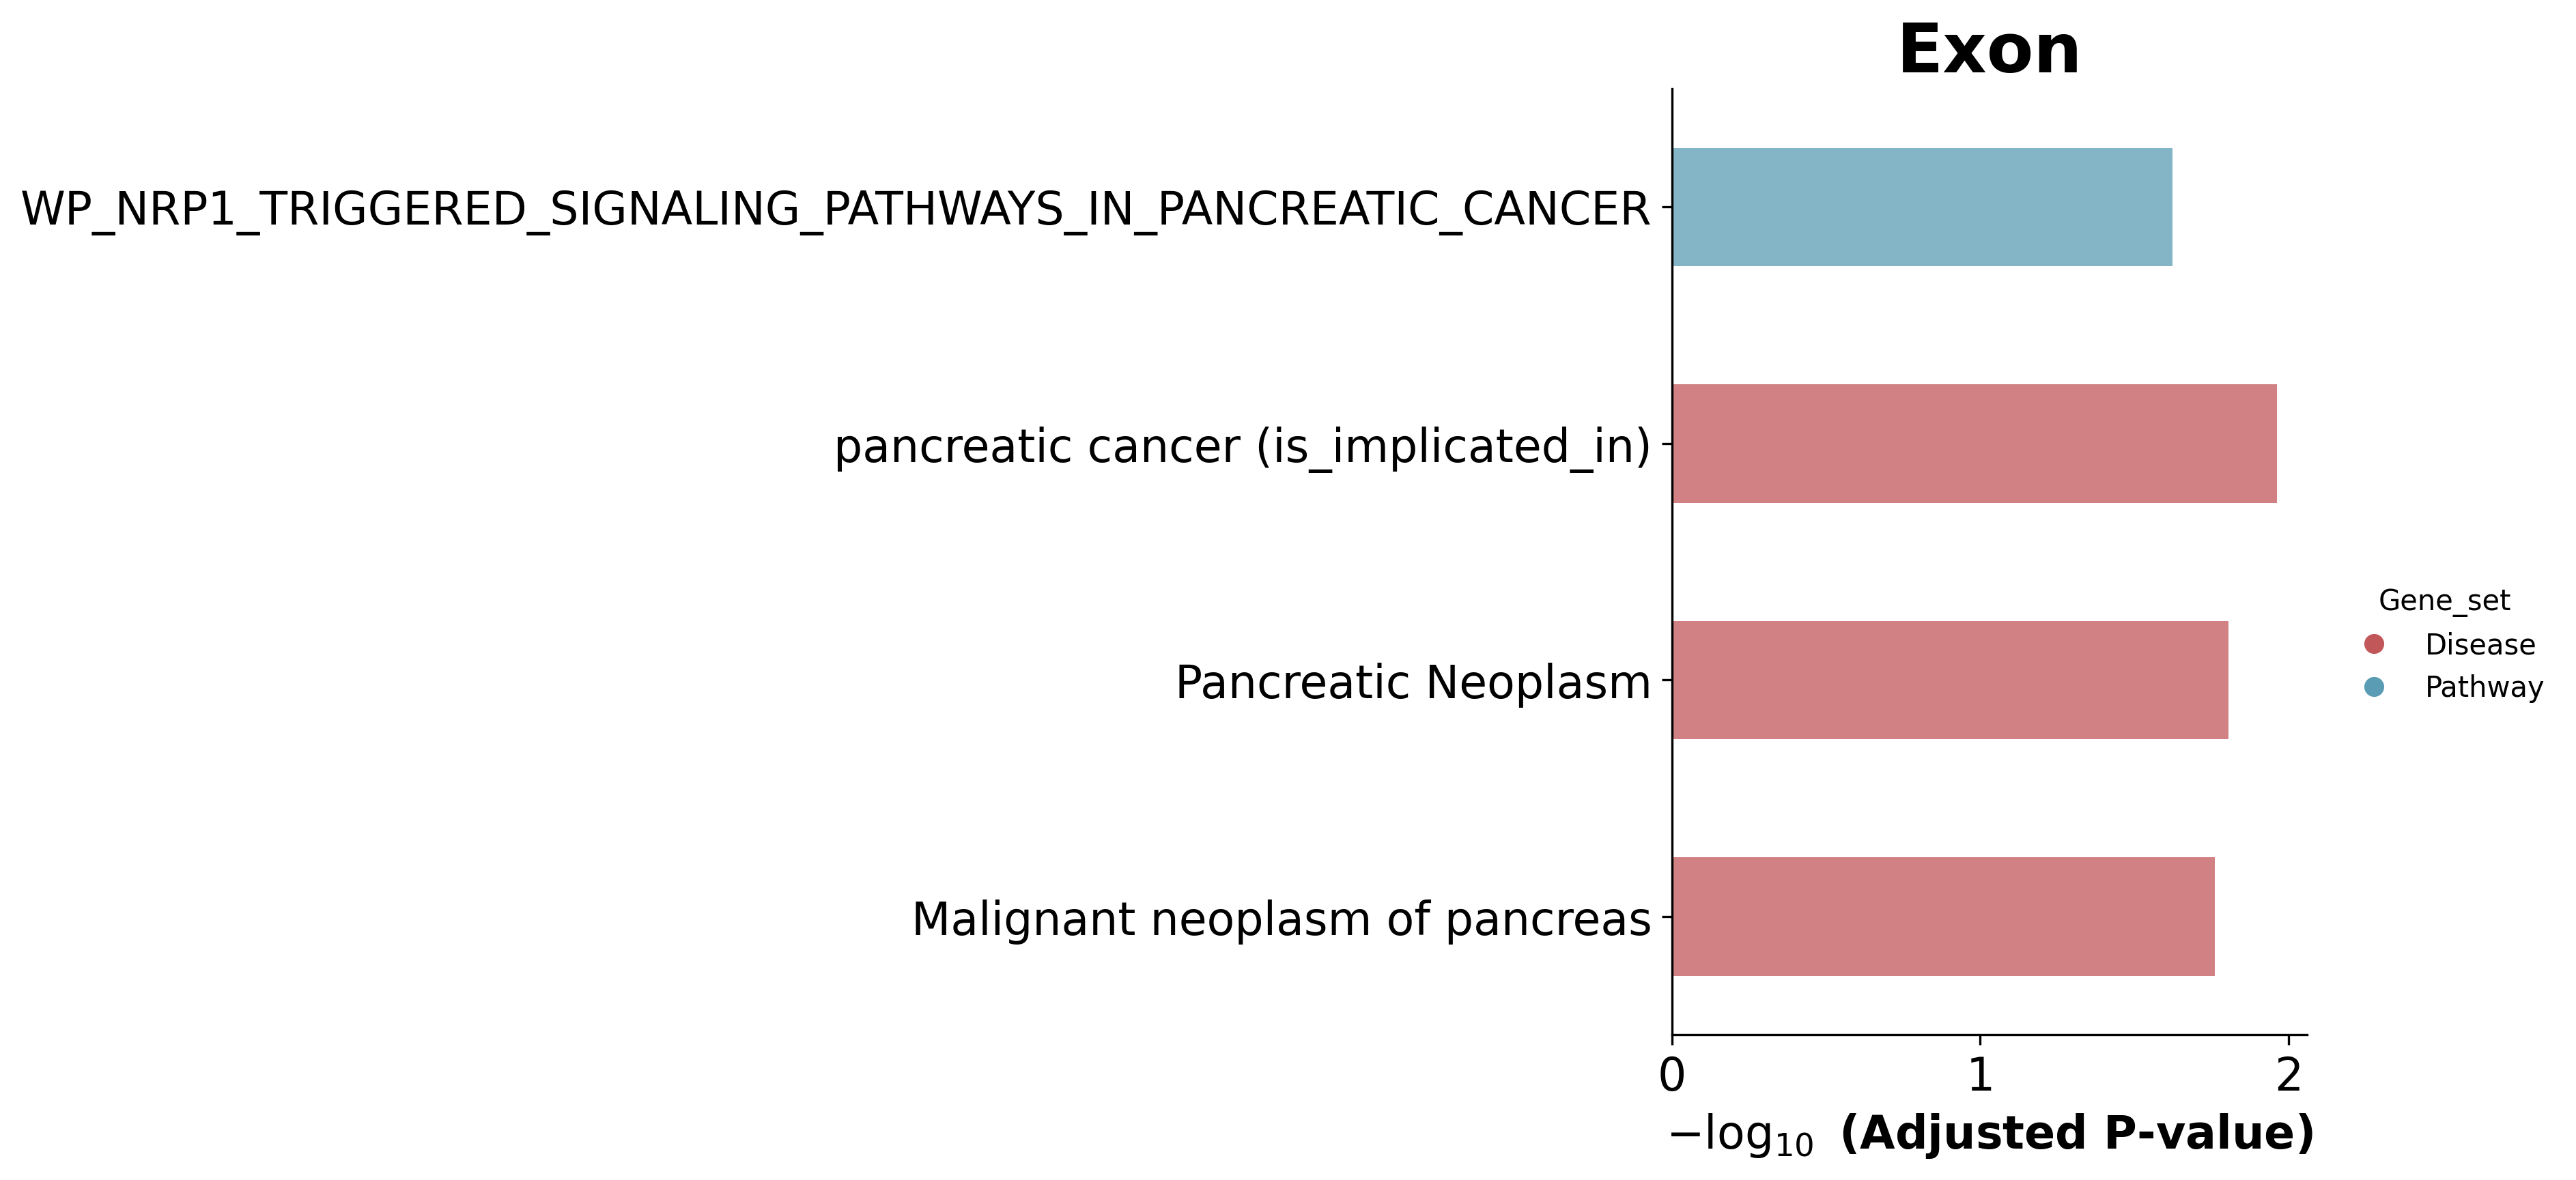

In [ ]:
with plt.rc_context({"figure.figsize":(5,4), "figure.dpi": (300)}):
    barplot(go_unique_exon_panc,title='Exon',group='Gene_set',color = ['#C25759', '#599CB4'])